In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance
from torchvision import transforms
import torch
import torch.nn as nn
from scipy.spatial.distance import hamming

In [2]:
def occlude(img, x, y, w = 50, h = 50, rgb = (80,80,80)):
    img[x:x + w,y:y + h] = rgb
    return img
    

In [10]:
preprocess1 = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
preprocess2 = transforms.Compose([
    transforms.Resize(33),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

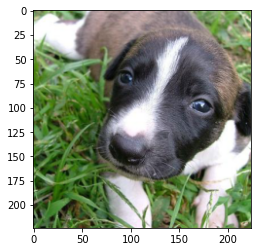

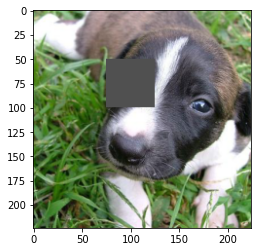

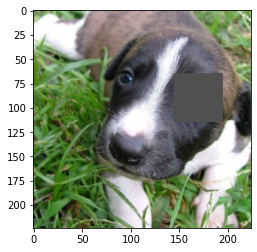

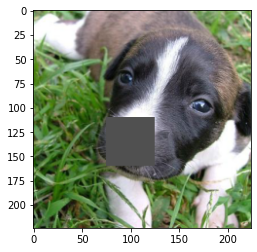

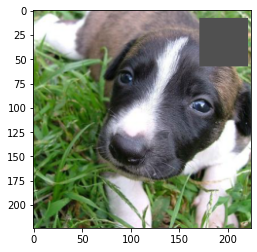

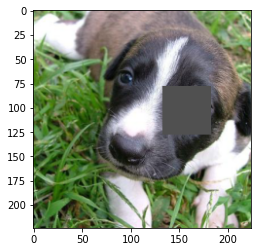

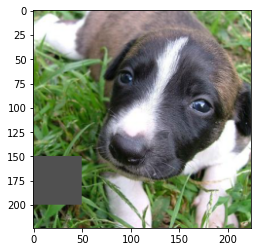

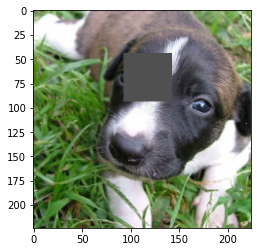

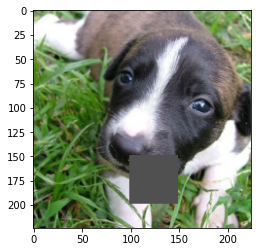

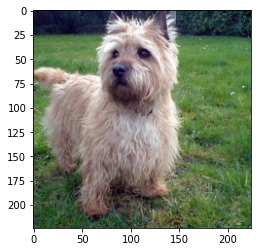

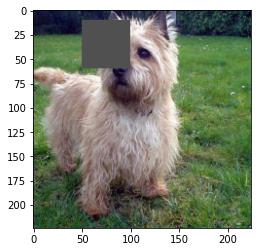

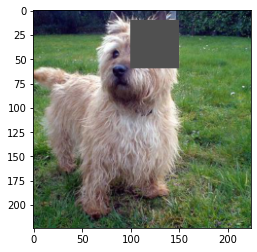

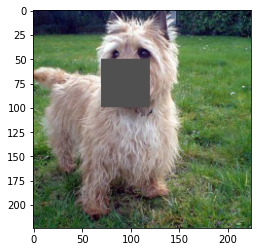

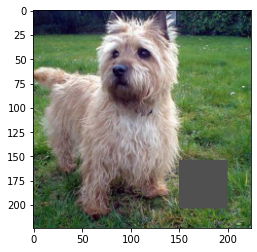

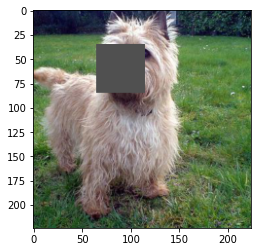

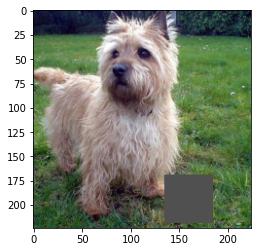

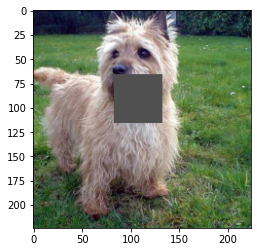

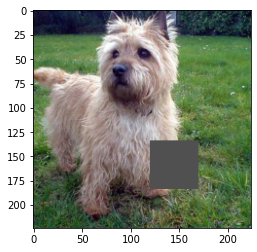

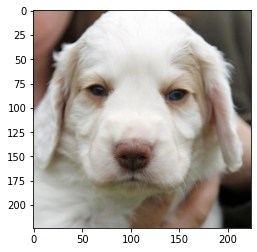

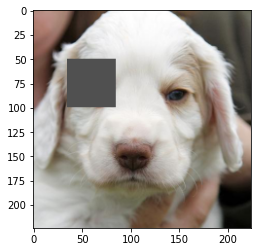

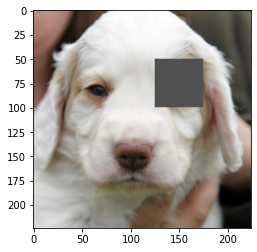

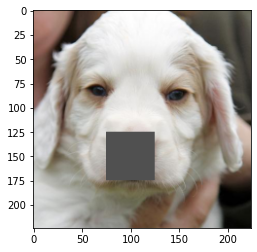

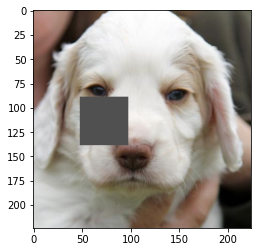

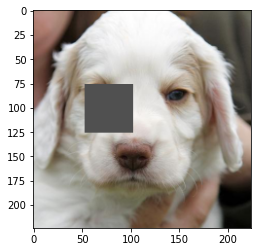

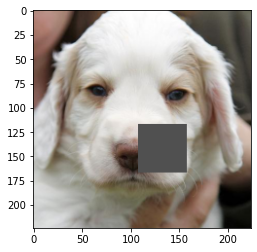

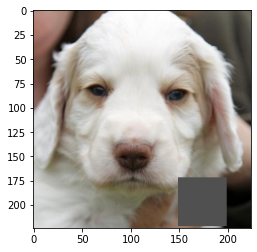

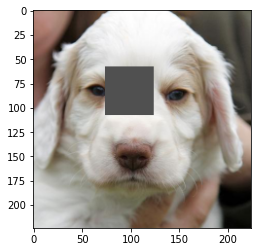

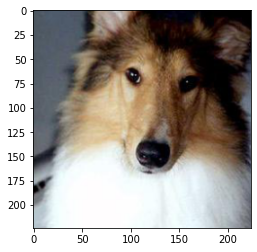

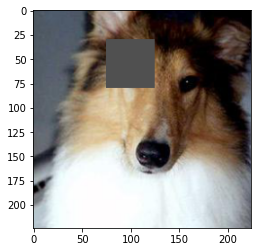

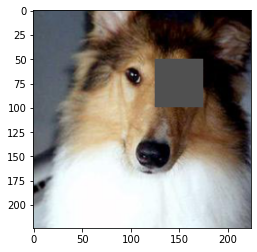

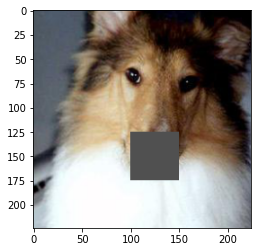

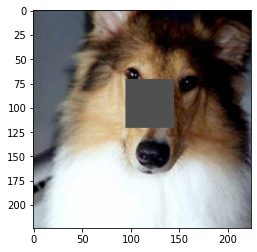

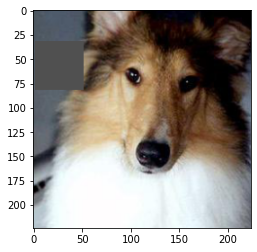

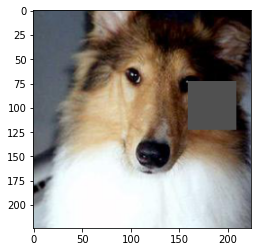

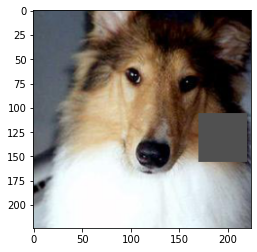

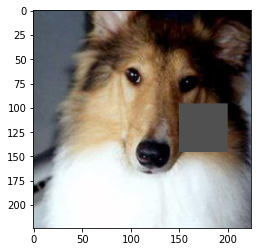

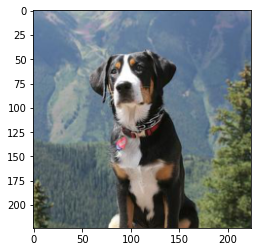

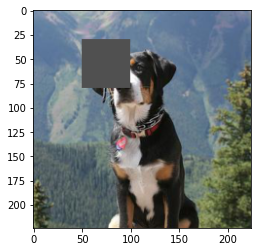

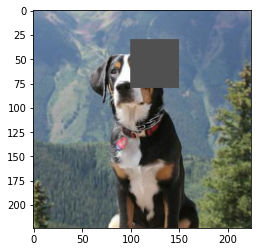

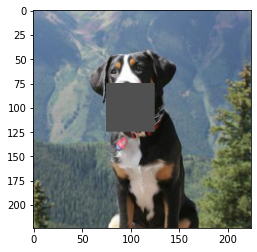

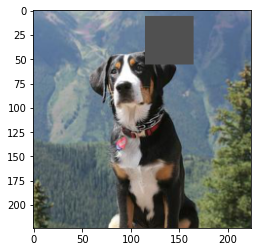

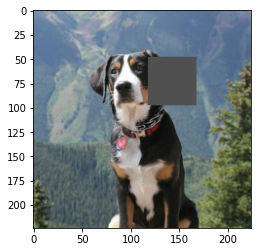

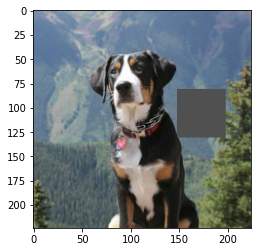

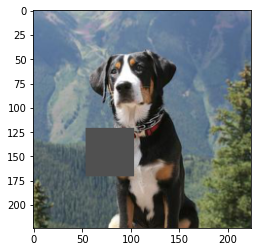

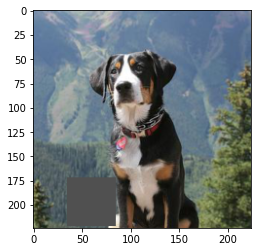

In [11]:
input_image_names = ['n02091134_2235.jpg', 'n02096177_91.jpg', 'n02101556_3100.jpg', 'n02106030_3948.jpg', 'n02107574_322.jpg']
left_eye_boxes = [[50,75], [10,50], [50,35], [30,75], [30,50]]
right_eye_boxes = [[65,145], [10,100], [50,125], [50,125], [30,100]]
nose_boxes = [[110,75], [50,70], [125,75], [125,100], [75,75]]
images = np.zeros((5,9,224,224,3))
for i, img in enumerate(input_image_names):
    input_image = Image.open(f'occlusion/{img}')
    input_tensor = preprocess1(input_image)
    input_batch = input_tensor.unsqueeze(0)
    orig_img = np.asarray(transforms.ToPILImage()(input_batch[0]).convert("RGB"), dtype=np.uint8)
    left_eye_img =  orig_img.copy()
    right_eye_img =  orig_img.copy()
    nose_img =  orig_img.copy()
    left_eye_img =  occlude(left_eye_img, left_eye_boxes[i][0], left_eye_boxes[i][1], 50, 50, (80,80,80))
    right_eye_img =  occlude(right_eye_img, right_eye_boxes[i][0], right_eye_boxes[i][1], 50, 50, (80,80,80))
    nose_img =  occlude(nose_img, nose_boxes[i][0], nose_boxes[i][1], 50, 50, (80,80,80))
#     left_eye_img[left_eye_boxes[i][0]:left_eye_boxes[i][0] + 50,left_eye_boxes[i][1]:left_eye_boxes[i][1] + 50] = (80,80,80)
#     right_eye_img[right_eye_boxes[i][0]:right_eye_boxes[i][0] + 50,right_eye_boxes[i][1]:right_eye_boxes[i][1] + 50] = (80,80,80)
#     nose_img[nose_boxes[i][0]:nose_boxes[i][0] + 50,nose_boxes[i][1]:nose_boxes[i][1] + 50] = (80,80,80)
    images[i,0,:,:,:] = orig_img
    images[i,1,:,:,:] = left_eye_img
    images[i,2,:,:,:] = right_eye_img
    images[i,3,:,:,:] = nose_img
    for j in range(5):
        x, y = np.random.randint(0, 223 - 50), np.random.randint(0, 223 - 50)
        new_img =  orig_img.copy()
        new_img = occlude(new_img, x, y, 50, 50, (80,80,80))
        images[i,4+j,:,:,:] = new_img

images_pil = []
        
for i in range(5):
    images_pil.append([])
    for j in range(9):
        new_img = images[i,j]
        images_pil[i].append(Image.fromarray(images[i,j].astype('uint8')))
        plt.imshow(new_img.astype('uint8'))
        plt.show()

In [6]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /home/vamsheedar/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
input_batches = []
for i in range(5):
    for j in range(9):
        input_tensor = preprocess2(images_pil[i][j])
        input_batch = input_tensor.unsqueeze(0)
        input_batches.append(input_batch)
        transforms.ToPILImage()(input_tensor).convert("RGB")

In [8]:
class Alex(torch.nn.Module):
    def __init__(self):
        super(Alex, self).__init__()
        pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
        features = list(pretrained.features)
        classifier = list(pretrained.classifier)
        self.features = nn.ModuleList(features).eval() 
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.ModuleList(classifier).eval() 
        
    def forward(self, x):
        self.results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {2,5,7,9,12}:
#                 print(ii, x.shape)
                self.results.append(x.detach().numpy())
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        for ii,model in enumerate(self.classifier):
            x = model(x)
#             print(ii, x.shape)
#             if ii in {2,5,7,9,12}:
#                 self.results.append(x.detach().numpy())
        return x, self.results

In [9]:
alex = Alex()

Using cache found in /home/vamsheedar/.cache/torch/hub/pytorch_vision_v0.10.0


In [10]:
alex, alex(input_batches[0])

(Alex(
   (features): ModuleList(
     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU(inplace=True)
     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU(inplace=True)
     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU(inplace=True)
     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace=True)
     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
   (classifier): ModuleList(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=9216, out_features=4

In [11]:
alex(input_batches[0])[0][0], torch.nn.functional.softmax(alex(input_batches[0])[0][0], dim=0)

(tensor([ 1.2224e+00, -5.4210e+00, -2.7916e+00, -2.1295e+00, -1.7963e+00,
         -2.1473e+00,  1.1824e-01, -2.1432e+00,  1.8427e-01, -6.5538e+00,
          1.6631e-01, -2.9045e+00, -3.6887e+00,  1.2872e+00, -1.8605e+00,
          1.9093e-01,  1.2431e+00, -1.5487e+00,  7.2086e+00,  6.9368e-01,
          9.8763e-01, -1.3919e+00, -3.1124e+00,  3.9242e+00, -1.0144e+00,
          1.5818e+00, -1.0825e-01, -1.7302e+00,  8.2150e-01, -5.1891e-01,
         -2.1676e-02, -2.8649e+00,  7.1087e-01,  2.1409e-01, -1.3429e-01,
          2.5204e+00,  7.0701e+00,  1.8965e+00,  8.0353e-01, -7.6470e-01,
         -1.8018e+00, -3.9750e+00, -1.5763e+00,  6.8189e-01, -3.2444e+00,
         -6.5894e-01, -2.0087e+00, -9.6629e-01, -3.5810e-01, -2.8406e+00,
         -3.7061e+00, -1.0345e+00, -1.6195e+00, -1.5635e+00,  2.4300e+00,
         -1.6075e+00,  1.2688e+00, -3.7863e+00, -2.6315e+00, -2.5583e+00,
         -1.1817e+00,  1.0009e+00,  9.3205e-01,  2.2884e-01, -1.1196e+00,
         -9.8833e-01, -2.2728e+00, -2.

In [12]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-12-02 14:28:21--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.3’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-12-02 14:28:21 (20.7 MB/s) - ‘imagenet_classes.txt.3’ saved [10472/10472]



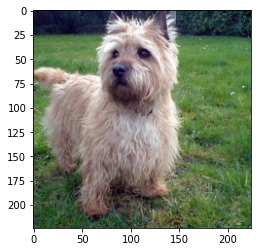

In [13]:
plt.imshow(images[1][0].astype('uint8'))
plt.show()

In [14]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
def run_alex_from_np_img(img):
    img_pil = Image.fromarray(img.astype('uint8'))
    input_tensor = preprocess2(img_pil)
    input_batch = input_tensor.unsqueeze(0)
    probs = torch.nn.functional.softmax(alex(input_batch)[0][0], dim=0)
    top5_prob, top5_catid = torch.topk(probs, 5)
#     print(top5_catid)
#     for i in range(top5_prob.size(0)):
#         print(categories[top5_catid[i]], top5_prob[i].item())
    return top5_prob, top5_catid, probs


In [15]:
categories = np.array(categories)
print(np.argwhere(categories=='whippet'))
print(np.argwhere(categories=='cairn'))
print(np.argwhere(categories=='clumber'))
print(np.argwhere(categories=='collie'))
print(np.argwhere(categories=='Greater Swiss Mountain dog'))
# categories

[[172]]
[[192]]
[[216]]
[[231]]
[[238]]


In [16]:
outputs = []
for i in range(5):
    outputs.append([])
    for j in range(9):
        img = images[i][j]
        img_pil = Image.fromarray(img.astype('uint8'))
        input_tensor = preprocess2(img_pil)
        input_batch = input_tensor.unsqueeze(0)
        outputs[i].append(alex(input_batch)[1])
    

In [17]:
[len(x) for x in outputs[0][0]]
# for x in outputs[0][0]:
#     print(x)
len(outputs[0][0][0]), outputs[0][0][0].shape

(1, (1, 64, 27, 27))

In [18]:
def epsilon_score(outputs=outputs):
    e = []
    for i in range(5):
        e.append([])
        for j in range(8):
            e[i].append([])
            for l in range(5):
                print(outputs[i][0][l][0], outputs[i][j+1][l][0])
                el = outputs[i][0][l][0] - outputs[i][j+1][l][0]
                e[i][j].append(el)
    return e

In [19]:
e = epsilon_score()

[[[ 4.3600636   4.3600636   0.6923941  ...  1.4187672   2.307889
    2.307889  ]
  [ 1.903794    0.          0.237953   ...  1.8566511   2.307889
    2.307889  ]
  [ 0.987521    0.          0.         ...  0.12231952  1.3201883
    0.8782285 ]
  ...
  [ 2.564213    5.0501137   5.044228   ...  0.          0.8670681
    1.0955379 ]
  [ 3.3345077   3.3345077   2.1249592  ...  2.1986744   0.6729587
    2.245291  ]
  [ 2.7753875   1.9484496   2.1249592  ...  2.1986744   0.
    1.2899392 ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 2.8362968   2.8362968   0.95414424 ...  0.          0.
    0.        ]
  [ 2.3714926   1.0974009   2.0021045  ...  0.          0.2116754
    0.07130218]
  [ 2.3714926   1.3542025   2.0021045  ...  0.          0.2116754
    0.07130218]]

 [[ 0.9038808   0.366121    1.4080958

    0.        ]]] [[[ 3.480263    2.2201583   5.056205   ...  3.650006    4.9429216
    5.6667924 ]
  [ 1.799266    0.02694595  0.         ...  0.          0.
    4.3702173 ]
  [ 5.1787834   0.          0.         ...  0.          0.3957965
    0.        ]
  ...
  [ 3.8853855   0.          0.         ...  3.318446    0.99883705
    0.9145845 ]
  [ 3.8853855   0.          0.         ...  3.318446    0.99883705
    0.        ]
  [ 2.6174133   0.53537583  2.4466293  ...  1.1110585   0.9405757
   10.407821  ]]

 [[ 2.2866533   0.9143728   1.0372523  ...  0.          0.
    1.6715144 ]
  [ 1.0869792   0.469287    0.         ...  0.          0.
    1.0430375 ]
  [ 1.0869792   0.469287    0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          1.2068012   0.         ...  0.          2.6926985
    2.6926985 ]
  [ 0.          0.          1.012094   ...  0.          0.
    1.360705  ]
  [ 0.25000826  0.13522647  2.4198978  ...  0.          0.
    0.0874094 ]]

 [[ 0.          0.    

[[[1.03932142e+00 4.65592337e+00 4.65592337e+00 ... 3.63248324e+00
   1.41067016e+00 1.26283038e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.62734509e+00
   2.62734509e+00 9.29916918e-01]
  [0.00000000e+00 0.00000000e+00 2.83316302e+00 ... 0.00000000e+00
   0.00000000e+00 3.95307273e-01]
  ...
  [1.76895022e+00 1.76895022e+00 1.22955143e+00 ... 2.54617453e+00
   5.97041249e-01 1.29604578e+00]
  [5.47551394e-01 0.00000000e+00 0.00000000e+00 ... 2.54617453e+00
   2.38600183e+00 2.38600183e+00]
  [1.81316388e+00 1.13600779e+00 3.03045559e+00 ... 4.34080791e+00
   2.65490270e+00 2.92957449e+00]]

 [[8.90965223e-01 0.00000000e+00 0.00000000e+00 ... 3.05374813e+00
   1.72621500e+00 2.71360254e+00]
  [2.59331346e-01 0.00000000e+00 0.00000000e+00 ... 1.40238142e+00
   4.68225867e-01 2.93086600e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.06935072e+00
   1.21645498e+00 2.93086600e+00]
  ...
  [0.00000000e+00 1.11947656e-01 1.67752469e+00 ... 0.00000000e+00
   0.00000

[[[0.07771789 0.         0.         ... 0.         0.         0.        ]
  [2.9174685  1.468648   0.         ... 0.         0.         0.        ]
  [0.94881403 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 2.6011953  1.9318306  0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

In [32]:
np.max(e[0][0][0], axis=0)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.    

In [38]:
def del_score(e=e):
    left = np.zeros((5,20))
    right = np.zeros((5,20))
    nose = np.zeros((5,20))
    random = np.zeros((5,100))
    cnt = 0
    for i in range(5):
        for j in range(5):
            if i==j:
                continue
            for l in range(5):
#                 print(i,j,l, cnt)
#                 print(left[l])
                
#                 print(hamming(np.sign(e[i][0][l]).flatten(), np.sign(e[j][0][l]).flatten()))
                left[l][cnt] = (hamming(np.sign(np.max(e[i][0][l], axis=0)).flatten(), np.sign(np.max(e[j][0][l], axis=0)).flatten()))
                right[l][cnt] = (hamming(np.sign(np.max(e[i][1][l], axis=0)).flatten(), np.sign(np.max(e[j][1][l], axis=0)).flatten()))                
                nose[l][cnt] = (hamming(np.sign(np.max(e[i][2][l], axis=0)).flatten(), np.sign(np.max(e[j][2][l], axis=0)).flatten()))     
                for m in range(5):
                    random[l][cnt*5+m] = (hamming(np.sign(np.max(e[i][3+m][l], axis=0)).flatten(), np.sign(np.max(e[j][3+m][l], axis=0)).flatten()))
            cnt+=1
            
    print(len(left[0]),np.array(left).shape)
    return np.array(left), np.array(right), np.array(nose), np.array(random)

In [38]:
def del_score(e=e):
    left = np.zeros((5,20))
    right = np.zeros((5,20))
    nose = np.zeros((5,20))
    random = np.zeros((5,100))
    cnt = 0
    for i in range(5):
        for j in range(5):
            if i==j:
                continue
            for l in range(5):
#                 print(i,j,l, cnt)
#                 print(left[l])
                
#                 print(hamming(np.sign(e[i][0][l]).flatten(), np.sign(e[j][0][l]).flatten()))
                left[l][cnt] = (hamming(np.sign(np.max(e[i][0][l], axis=0)).flatten(), np.sign(np.max(e[j][0][l], axis=0)).flatten()))
                right[l][cnt] = (hamming(np.sign(np.max(e[i][1][l], axis=0)).flatten(), np.sign(np.max(e[j][1][l], axis=0)).flatten()))                
                nose[l][cnt] = (hamming(np.sign(np.max(e[i][2][l], axis=0)).flatten(), np.sign(np.max(e[j][2][l], axis=0)).flatten()))     
                for m in range(5):
                    random[l][cnt*5+m] = (hamming(np.sign(np.max(e[i][3+m][l], axis=0)).flatten(), np.sign(np.max(e[j][3+m][l], axis=0)).flatten()))
            cnt+=1
            
    print(len(left[0]),np.array(left).shape)
    return np.array(left), np.array(right), np.array(nose), np.array(random)

In [39]:
left, right, nose, rand = del_score()

20 (5, 20)


In [60]:
np.mean(left, axis=1)

array([0.0994513 , 0.16772066, 0.14896604, 0.21072947, 0.37607422])

In [35]:
left.shape, left[0], left[1], left[2]

((5, 100),
 array([0.11779835, 0.16709813, 0.14287475, 0.20481232, 0.38085938,
        0.10821759, 0.17982618, 0.15329142, 0.22420488, 0.4015842 ,
        0.07276663, 0.15134985, 0.15540249, 0.22263314, 0.39670139,
        0.10015861, 0.17378575, 0.15523299, 0.22774131, 0.40223524,
        0.11779835, 0.16709813, 0.14287475, 0.20481232, 0.38085938,
        0.11771262, 0.18438733, 0.14293639, 0.19965791, 0.35091146,
        0.10294496, 0.1507643 , 0.14557138, 0.18872504, 0.3266059 ,
        0.07008745, 0.13116371, 0.12392135, 0.17400148, 0.32096354,
        0.10821759, 0.17982618, 0.15329142, 0.22420488, 0.4015842 ,
        0.11771262, 0.18438733, 0.14293639, 0.19965791, 0.35091146,
        0.12139918, 0.19918023, 0.16270648, 0.22538369, 0.38867188,
        0.09619342, 0.17659024, 0.15091839, 0.21770987, 0.39605035,
        0.07276663, 0.15134985, 0.15540249, 0.22263314, 0.39670139,
        0.10294496, 0.1507643 , 0.14557138, 0.18872504, 0.3266059 ,
        0.12139918, 0.19918023, 0.162

In [40]:
np.mean(left, axis=1), np.mean(right, axis=1), np.mean(nose, axis=1), np.mean(rand, axis=1)

(array([0.09876543, 0.15147929, 0.14319527, 0.13491124, 0.21111111]),
 array([0.10864198, 0.19053254, 0.18816568, 0.16923077, 0.21666667]),
 array([0.12674897, 0.2591716 , 0.30295858, 0.30414201, 0.01111111]),
 array([0.16823045, 0.35195266, 0.42414201, 0.42911243, 0.27333333]))

In [66]:
np.std(left, axis=1), np.std(right, axis=1), np.std(nose, axis=1), np.std(rand, axis=1)

(array([0.01724973, 0.01855671, 0.01032322, 0.01733113, 0.02976935]),
 array([0.02917535, 0.02749426, 0.01367537, 0.01605167, 0.03284663]),
 array([0.02848808, 0.03606112, 0.0169755 , 0.01992511, 0.03086205]),
 array([0.0233057 , 0.04287153, 0.02064794, 0.0290421 , 0.05032581]))

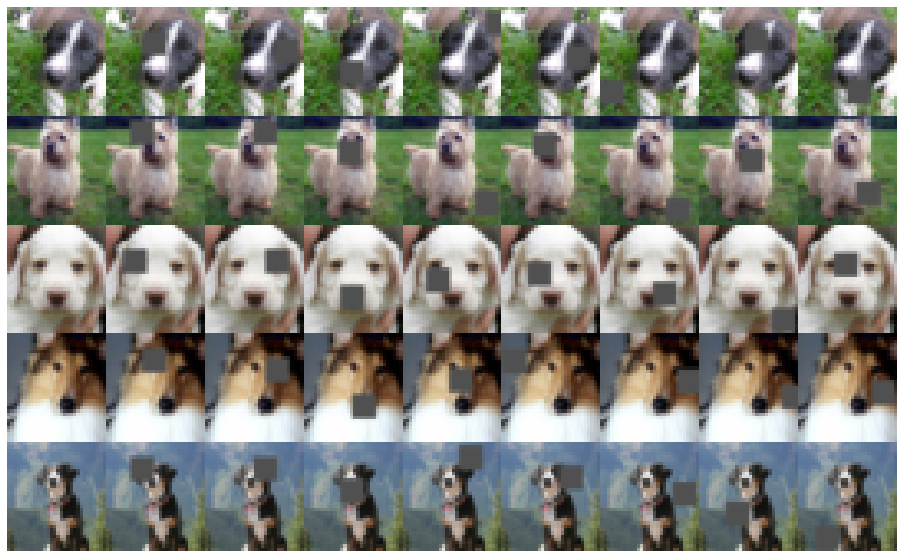

In [30]:
img = np.zeros((165,270,3))
for i in range(5):
    for j in range(9):
#         print(i,j, len(input_batches))
        img1 = images[i][j]
#         plt.imshow(images[i][j].astype('uint8'))
#         plt.imshow(np.asarray(transforms.ToPILImage()(input_batch[0]).convert("RGB"), dtype=np.uint8))
#         plt.show()
#         print(img[i*33:(i+1)*33,j*30:(j+1)*30,:].shape, j*30,(j+1)*30, img.shape)
#         print(np.asarray(transforms.ToPILImage()(input_batch[0]).convert("RGB"), dtype=np.uint8)[:,:30,:].shape)
        img_pil = Image.fromarray(img1.astype('uint8'))
        input_tensor = preprocess2(img_pil)
        input_batch = input_tensor.unsqueeze(0)
        img[i*33:(i+1)*33,j*30:(j+1)*30,:] = np.asarray(transforms.ToPILImage()(input_batch[0]).convert("RGB"), dtype=np.uint8)[:,:30,:]
        
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.savefig("correspondence.png", bbox_inches='tight')
plt.show()


        
